# Lab 13: Misc Practice

In [92]:
options(repr.plot.width=6, repr.plot.height=4)

library(tidyverse)
library(stringr)
library(tidytext)
library(lubridate)
library(nycflights13)
library(scales)

## Q1: Working with logicals

### 1.1

Given a logical vector, consider a function that returns `TRUE` if every element is `TRUE`, and returns `FALSE` if any element is `FALSE`. Have this function ignore missing values (don't worry about empty vectors or vectors will all missing values).

Write the function `all_iter` which uses iteration/loops to perform this calculation.

Write the function `all_func` which uses functional programming tools.

In [30]:
all_iter = function(x) {
    for (val in x) {
        if (!is.na(val)) {
            if (!val) {
                return(FALSE)
            }
        }
    }
    return(TRUE)
}

In [31]:
all_func = function(x) {
    x %>% keep(~!is.na(.)) %>% reduce(`&`)
}

In [32]:
stopifnot(all_iter(c(TRUE, TRUE, TRUE)))
stopifnot(!all_iter(c(TRUE, TRUE, FALSE)))
stopifnot(!all_iter(c(FALSE, FALSE, FALSE)))
stopifnot(all_iter(c(TRUE, TRUE, NA)))
stopifnot(!all_iter(c(TRUE, FALSE, NA)))
stopifnot(all_iter(c(NA, TRUE, NA)))

stopifnot(all_func(c(TRUE, TRUE, TRUE)))
stopifnot(!all_func(c(TRUE, TRUE, FALSE)))
stopifnot(!all_func(c(FALSE, FALSE, FALSE)))
stopifnot(all_func(c(TRUE, TRUE, NA)))
stopifnot(!all_func(c(TRUE, FALSE, NA)))
stopifnot(all_func(c(NA, TRUE, NA)))

### 1.2

Now consider the function that does the opposite, returns `TRUE` if any of the elements are `TRUE`, and returns `FALSE` if all of the elements are `FALSE`.

Write a function `any_func` that does this. Hint: this function can be written extremely simply given a correct implementation of `all_func` or `all_iter` if you think carefully about what this is doing.

In [35]:
any_func = function(x) {
    !all_func(!x)
}

In [36]:
stopifnot(any_func(c(TRUE, TRUE, TRUE)))
stopifnot(any_func(c(TRUE, TRUE, FALSE)))
stopifnot(!any_func(c(FALSE, FALSE, FALSE)))
stopifnot(any_func(c(TRUE, TRUE, NA)))
stopifnot(any_func(c(TRUE, FALSE, NA)))
stopifnot(!any_func(c(FALSE, FALSE, NA)))
stopifnot(any_func(c(NA, TRUE, NA)))

Note that `any` and `all` are built-in `R` functions that do the same things as the above functions you wrote.

### 1.3

Write a function `exists_outlier` that takes a vector and checks if an outlier exists. We define an outlier to be a point that is more than 2.5x the standard deviation away from the mean.

In [50]:
exists_outlier = function(x) {
    any(abs(x - mean(x)) > 2.5*sd(x))
}

In [51]:
stopifnot(!exists_outlier(c(1, 2, 3, 4, 5)))
stopifnot(exists_outlier(c(rep(1, 20), 5)))

### 1.4

The following code creates a dataframe `dat`. Write a one-liner using `exists_outlier` that prints the variable names of `dat` that contain an outlier.

In [78]:
set.seed(123515)
dat = data.frame(X1=rnorm(30))
for (varn in 2:20) {
    dat[[paste0('X', varn)]] = rnorm(30)
}

In [79]:
names(dat)[map_lgl(dat, exists_outlier)] %>% print

[1] "X1"  "X2"  "X5"  "X14" "X17"


## Q2: Max and Argmax

### 2.1

Define the function `max_iter` that takes a vector and returns the maximum element by iterating through the elements of the vector.

Define the function `max_func` that does the same thing using `reduce`. Note: don't use the `max` function, instead define your own function that goes into the reduce.

In [211]:
max_iter = function(x) {
    curr = x[1]
    
    for (i in 2:length(x)) {
        if (x[i] > curr) {
            curr = x[i]
        }
    }
    curr
}


In [212]:
reduce_max = function(curr, newval) {
    if (newval > curr) {
        return(newval)
    } else {
        return(curr)
    }
}

max_func = function(x) {
    reduce(x, reduce_max)
}

In [213]:
test = rnorm(100)
stopifnot(max_iter(test) == max(test))
stopifnot(max_func(test) == max(test))

### 2.2

Define the function `argmax_iter` that takes a vector and returns the index maximum element using iteration/loops. If there is a tie return the index of the first time the max appears. Hint: you may need to keep track of multiple things as you iterate.

(Difficult) Define the function `argmax_func` that does the same thing using reduce. Hint: how can you keep track of multiple things through the reduce steps?


In [214]:
argmax_iter = function(x) {
    curr_val = x[1]
    curr_arg = 1
    
    for (i in 2:length(x)) {
        if (x[i] > curr_val) {
            curr_val = x[i]
            curr_arg = i
        }
    }
    curr_arg
}

In [215]:
reduce_argmax = function(curr, newval) {
    if (newval > curr$val) {
        return(list(val=newval, arg=curr$i+1, i=curr$i+1))
    } else {
        return(list(val=curr$val, arg=curr$arg, i=curr$i+1))
    }
}

argmax_func = function(x) {
    res = reduce(x, reduce_argmax, .init=list(val=-Inf, arg=0, i=0))
    res$arg
}

In [216]:
test = rnorm(100)
stopifnot(argmax_iter(c(1, -3, 2, 6, 3)) == 4)
stopifnot(argmax_iter(test) == which.max(test))
stopifnot(argmax_func(c(1, -3, 2, 6, 3)) == 4)
stopifnot(argmax_func(test) == which.max(test))

## Q3: News Headlines

We are going to look through headlines from ABC News. The following loads the dataset we will use.


In [105]:
headlines = read_csv('https://raw.githubusercontent.com/rogerfan/stats306_f18_labs/master/abcnews_2017.csv', 
                     col_types=list(col_character(), col_character()))
sents = get_sentiments("afinn")

head(headlines)
head(sents)

publish_date,headline_text
20170101,1986 queensland cabinet documents released
20170101,actor william cristopher mash chaplain dead at 84
20170101,adelaide hip hop artist dreams becoming influential in australia
20170101,adelaide's new year's fireworks
20170101,adelaides new years fireworks
20170101,ambulances ferry injured to hospital istanbul nightclub attack


word,score
abandon,-2
abandoned,-2
abandons,-2
abducted,-2
abduction,-2
abductions,-2


### 3.1

Create `headlines1` in which `publish_date` is converted the appropriate date format and there is an additional `id` variable that gives each headline a unique id number.

In [35]:
headlines1 = headlines %>% 
    mutate(publish_date=ymd(publish_date),
           id=row_number())

head(headlines1)

publish_date,headline_text,id
2017-01-01,1986 queensland cabinet documents released,1
2017-01-01,actor william cristopher mash chaplain dead at 84,2
2017-01-01,adelaide hip hop artist dreams becoming influential in australia,3
2017-01-01,adelaide's new year's fireworks,4
2017-01-01,adelaides new years fireworks,5
2017-01-01,ambulances ferry injured to hospital istanbul nightclub attack,6


### 3.2

Using `headlines1` and the `sents` dataset we loaded (which contains sentiment scores for each word), create `headlines2`, which adds a variable called `score` that contains the sentiment score for that word. Note that the sentiment score is simply the sum of the sentiment scores for each word in the headline.

In [101]:
headlines2 = headlines1 %>% unnest_tokens(word, headline_text) %>% 
    left_join(sents) %>% group_by(id) %>%
    summarize(score=sum(score, na.rm=TRUE)) %>%
    inner_join(headlines1)

head(headlines2)

Joining, by = "word"
Joining, by = "id"


id,score,publish_date,headline_text
1,0,2017-01-01,1986 queensland cabinet documents released
2,-3,2017-01-01,actor william cristopher mash chaplain dead at 84
3,3,2017-01-01,adelaide hip hop artist dreams becoming influential in australia
4,0,2017-01-01,adelaide's new year's fireworks
5,0,2017-01-01,adelaides new years fireworks
6,-3,2017-01-01,ambulances ferry injured to hospital istanbul nightclub attack


### 3.3

Write a function `get_headlines` that takes a string `keyword` as an argument and returns a subset of `headlines2` with only rows where the headline contains the given `keyword`. The returned dataframe should contain an additional column titled `keyword` that contains the keyword provided to the function.

In [47]:
get_headlines = function(keyword) {
    result = headlines2 %>% 
        filter(str_detect(headline_text, keyword)) %>%
        mutate(keyword=keyword)
    return(result)
}

head(get_headlines('iran'))

id,score,publish_date,headline_text,keyword
841,0,2017-01-09,iran ex preisdent akbar hashemi rafsanjani dies,iran
1924,-1,2017-01-18,irans rouhani says talk about renegotiating nuclear deal empty,iran
3402,-3,2017-01-30,donald trump travel ban stops iranian scientist returning to us,iran
3455,-2,2017-01-30,oscar nominated iranian director asghar farhadi travel ban,iran
3836,-2,2017-02-01,un calls emergency meeting over iran missile,iran
4039,0,2017-02-02,white house puts iran on notice over ballistic missile test,iran


### 3.4

Using `get_headlines`, create a dataframe `headlines4` which, for each country in `country_interest`, contains the headlines associated with that country. The result should be a single dataframe. You should be able to do this with a one-liner.

In [86]:
country_interest = c('china', 'india', 'russia', 'syria', 'indonesia',
                     'japan', 'israel', 'iraq', 'iran', 'philippines',
                     'united states', 'france')

headlines4 = map_dfr(country_interest, get_headlines)
# headlines4 = reduce(map(country_interest, get_headlines), rbind)

head(headlines4)

id,score,publish_date,headline_text,keyword
193,0,2017-01-03,human hair and rocket launchers now cheaper to export to china,china
388,-4,2017-01-04,two wounded one dead after gun rampage in china,china
424,0,2017-01-05,china to spend $493 billion on renewable fuel by 2020,china
434,-4,2017-01-05,economists fear official uschina trade war as yuan,china
531,2,2017-01-05,wine exporters to benefit from further china tariff reduction,china
554,0,2017-01-06,china harbin ice festival begins with spectacular sculptures,china


### 3.5

Do whatever data management and plotting you need to replicate the following plot using `headlines4`. 

If you want to match the colors exactly, the colors I use for the endpoints of my scale are `muted('red')` and `muted('green')`.

![stats306_lab13_prob3.png]

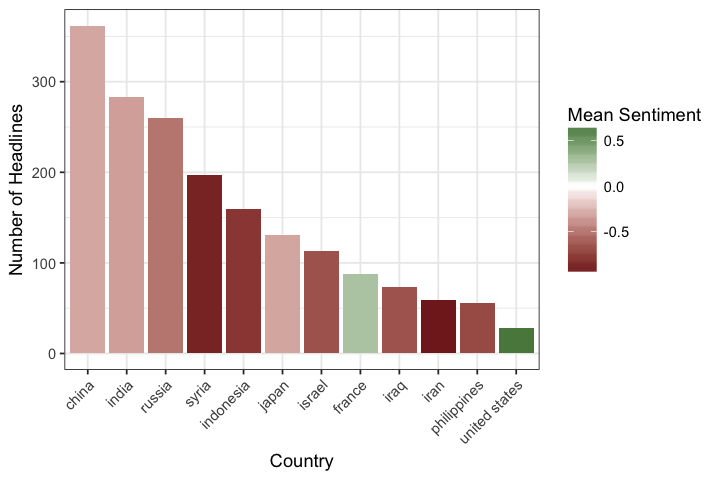

In [100]:
res = headlines4 %>% group_by(keyword) %>% 
      summarize(n=n(), mean_score=mean(score))

ggplot(data=res, aes(x=reorder(keyword, -n), y=n, fill=mean_score)) + 
    geom_bar(stat='identity') + 
    scale_fill_gradient2(low=muted('red'), mid='white', 
                         high=muted('green'), midpoint=0) + 
    labs(x='Country', y='Number of Headlines', fill='Mean Sentiment') +
    theme_bw() +
    theme(axis.text.x = element_text(angle=45, hjust=1))

## Q4: Regex

### 4.1

Write a regex pattern `pattern1` that matches phone numbers where the area code and next three digits are the same (e.g. `123-123-4567`). For this problem, only consider phone numbers in the formats `123-456-7890` and `(123) 456-7890` to be valid.

In [141]:
pattern1 = '^(\\((\\d{3})\\)\\s|(\\d{3})-)(\\2|\\3)-\\d{4}$'

In [142]:
match_these = c(
    '123-123-1754',
    '(296) 296-4164'
)

dont_match_these = c(
    '123-234-1754',
    '(296) 111-4164',
    '(975) 123 8134',
    '123-123 1754',
    '123 123 1754',
    '(296)-296-4164',
    '(296-296-4164',
    '296)-296-4164'
)

str_view(match_these, pattern1)
str_view(dont_match_these, pattern1)

HTML widgets cannot be represented in plain text (need html)

HTML widgets cannot be represented in plain text (need html)

### 4.2

Write a regex pattern `pattern2` that matches all the valid email addresses in `match_these` but none of the invalid ones in `dont_match_these`.

In [145]:
pattern2 = '^\\w+[\\w+.-]+@\\w+[\\w-]+(\\.[\\w-]+)+$'

In [146]:
match_these = c(
    'firstname.lastname@domain.com',
    'email@subdomain.domain.com',
    'firstname+lastname@domain.com',
    'email@123.123.123.123',
    '1234567890@domain.com',
    'email@domain-one.com',
    '_______@domain.com',
    'email@domain.name',
    'email@domain.co.jp',
    'firstname-lastname@domain.com'
)

dont_match_these = c(
    'plainaddress',
    '#@%^%#$@#$@#.com',
    '@domain.com',
    'Joe Smith <email@domain.com>',
    'email.domain.com',
    'email@domain@domain.com',
    '.email@domain.com',
    'email@domain.com (Joe Smith)',
    'email@domain',
    'email@-domain.com',
    'email@domain..com'
)

str_view(match_these, pattern2)
str_view(dont_match_these, pattern2)

HTML widgets cannot be represented in plain text (need html)

HTML widgets cannot be represented in plain text (need html)